# Ön Bilgi
**Geliştiren :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesi Adı :** 20 Newsgroups - (http://qwone.com/~jason/20Newsgroups)

**Veri Kümesinin İçeriği :** Her biri farklı bir konuya karşılık gelen 20 farklı haber grubuna ayrılmış 10.000'den fazla belge bulunmaktadır.

**Tweet Sınıfları :** 

0. alt.atheism
1. comp.graphics
2. comp.os.ms-windows.misc
3. comp.sys.ibm.pc.hardware
4. comp.sys.mac.hardware
5. comp.windows.x
6. misc.forsale
7. rec.autos
8. rec.motorcycles
9. rec.sport.baseball
10. rec.sport.hockey
11. sci.crypt
12. sci.electronics
13. sci.med
14. sci.space
15. soc.religion.christian
16. talk.politics.guns
17. talk.politics.mideast
18. talk.politics.misc
19. talk.religion.misc

**Veri Kümesi Referansı :** Ken Lang tarafından oluşturulmuştur.

**Algoritma :** Long Short-Term Memory (LSTM)

**Ağ Mimarisi :** 

- LSTM(2)
- LSTM(2)
- Dense(20)

**batch_size :** 2048

**epochs :** 6

**Doğruluk Oranı :** %95


---



In [1]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Sets/20_newsgroup.csv', sep=',')
df = df.drop(['date', 'title', 'Unnamed: 0'	], axis=1)
pd.DataFrame(df)

,text,target
0,I was wondering if anyone out there could enli...,7
1,I recently posted an article asking what kind ...,7
2,\nIt depends on your priorities. A lot of peo...,7
3,an excellent automatic can be found in the sub...,7
4,: Ford and his automobile. I need information...,7
...,...,...
11309,Secrecy in Clipper Chip\n\nThe serial number o...,11
11310,Hi !\n\nI am interested in the source of FEAL ...,11
11311,"The actual algorithm is classified, however, t...",11
11312,\n\tThis appears to be generic calling upon th...,11


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silelim : 

In [3]:
df.isnull().sum()

text      218
target      0
dtype: int64

In [4]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

text      0
target    0
dtype: int64

### Gereksiz Verileri Kaldıralım :  

In [5]:
nltk.download('stopwords')
stop_word_list = stopwords.words('english')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [6]:
def preprocess_text(sen):
    
    # URL Silme İşlemi
    sentence = re.sub(r'http\S+', '', str(sen))

    # E-Mail Adresi Silme İşlemi
    sentence = re.sub('\S+@\S+', '', str(sentence))

    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sentence))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [7]:
x = df['text']
y = df['target']

In [8]:
x = x.apply(preprocess_text)
pd.DataFrame(x)

,text
0,wondering anyone could enlighten car saw day i...
1,recently posted article asking kind rates sing...
2,it depends priorities lot people put higher pr...
3,excellent automatic found subaru legacy switch...
4,ford automobile need information whether ford ...
...,...
11091,secrecy clipper chip the serial number clipper...
11092,hi interested source feal encryption algorithm...
11093,the actual algorithm classified however main t...
11094,this appears generic calling upon name anti ch...


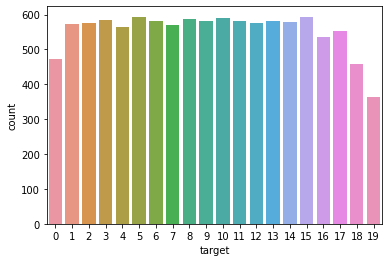

In [9]:
sns.countplot(y)

## Kelimeleri Sayılara Dönüştürelim : 

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [10]:
token = Tokenizer()
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [11]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12337,12338,12339,12340,12341,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374,12375,12376
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,673,93,2781,178,13106,1449,5227,58,449,36017,1117,19239,458,28,52,1117,1385,132,16,493,208,744,19240,10391,47,63,7350,24,1472,6709,3958,36018,9,44,67,568,51,368,66,3
3453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7948,7241,7241,6336,931,931,6336,12824,7698,7698,12824,12032,11695,11695,12032,3,3671,3414,20817,2640,4175,38,2816,61,5176,272,996,1485,84,553,2946,2946,989,459,923,989,4495,989,11693,4697
5948,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15170,1674,7551,685,15170,3928,7551,685,15170,5821,3273,1116,25419,4405,107,1019,1299,3028,16680,737,2,2135,19,345,705,610,38,1019,107,15179,338,4077,107,6569,9,319,1627,269,1564,96
7016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11222,5168,12462,275,55476,55477,267,1681,798,2081,593,1024,2713,487,4823,603,349,2629,4114,1743,11,74,131,23,44,182,4195,201,3738,106,90,420,698,14,67,74,131,79,666,590
5949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# X Verilerimizi Düzenleyelim : 

---



## Ölçeklendirelim

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

**Örnek :**

İki farklı insan düşünelim. Bu insanların birisinin geliri ayda 5.000 Türk Lirası iken diğerinin geliri ayda 200.000 Türk Lirası olsun. Bu insanların ikisi de her ay belirli miktarda maddi yardım için maaşlarının bir kısmını ayırıyorlar. Diyelim ki 5.000 Türk Lirası maaşı olan şahıs 1.500 Türk Lirasını yardıma ayırıyorken, 200.000 Türk Lirası alan şahıs 10.000 Türk Lirasını yardım için ayırıyor.

Normal bir gözle bakarsak 10.000 Türk Lirası yardımda bulunan kişinin daha fazla yardım yaptığını görürüz. Fakat bunu oranladığımızda 5.000 Türk Lirası alan kişinin oransal olarak kat kat fazla yardım yaptığı anlaşılacaktır. İşte özellik ölçeklendirme ile biz bu özelliklerin sayısal değerlerinin birbirine yakın olmasını sağlayıp aralarındaki değerleri karşılaştırmak yerine oranları karşılaştırırız.

In [12]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [13]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12337,12338,12339,12340,12341,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374,12375,12376
10216,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,...,-0.261023,0.328286,-0.331224,-0.331906,-0.270826,8.111092,-0.343114,1.505101,-0.145904,-0.337908,-0.367066,-0.365179,-0.371534,0.915328,-0.329691,-0.336897,-0.300855,0.002621,-0.264191,-0.387900,-0.096160,-0.404325,-0.342721,-0.345440,-0.367385,-0.396077,-0.252081,0.034977,-0.413347,-0.357340,1.225800,-0.375833,0.844175,0.278210,-0.454164,-0.432719,-0.343712,0.066036,-0.421335,-0.524057
7650,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,...,-0.332348,-0.316832,-0.300113,-0.160884,-0.326353,-0.058238,-0.352293,-0.347838,1.338334,0.454050,-0.369925,-0.093921,-0.294975,-0.108426,0.087430,0.078546,-0.329484,-0.103611,-0.346201,-0.393380,-0.350516,-0.404674,-0.403148,-0.380705,6.016581,-0.245940,-0.431961,-0.429927,1.001619,-0.186543,-0.386916,-0.395468,-0.437913,-0.430077,-0.098989,-0.311797,0.449007,-0.048428,-0.450729,-0.532271
726,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,...,2.979235,0.254035,0.275962,-0.285935,0.239511,0.259259,-0.350508,0.000390,-0.004910,-0.140453,-0.136117,-0.304589,-0.364586,-0.368252,-0.328789,-0.383680,0.091801,-0.059259,-0.309726,-0.304645,0.087351,-0.359190,-0.208122,-0.416310,0.961932,-0.350575,-0.405023,-0.015036,-0.230084,-0.368545,-0.432404,-0.221954,-0.431384,-0.150352,2.542198,2.436509,-0.286309,-0.436687,-0.082652,-0.366759
4748,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,...,-0.300860,-0.330884,0.404360,-0.155822,-0.326353,-0.229524,-0.181717,-0.351214,-0.358051,-0.351393,-0.339903,-0.339827,-0.372306,-0.364586,-0.360102,-0.380147,-0.366258,-0.380544,0.705937,0.175059,-0.368997,-0.249029,-0.250303,-0.406928,-0.396126,0.318454,1.226363,-0.208089,-0.388111,-0.170333,-0.358652,0.770592,-0.431716,-0.337988,-0.449028,-0.439870,-0.418357,-0.436270,-0.458900,-0.507721
4380,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,-0.009494,...,-0.338793,-0.336945,-0.338079,-0.3

## LSTM için X'i 3 Boyutlu Hale Getirelim

In [14]:
print('x : ' + str(x.shape))

x : (11096, 12377)


In [15]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
print('x : ' + str(x.shape))

x : (11096, 12377, 1)


# Y Verilerimizi Düzenleyelim :  


---

## One Hot Encoding Uygulayalım

**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [16]:
pd.DataFrame(y).sample(5)

,target
2184,14
2979,13
1879,14
9412,15
6571,12


In [17]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
9265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [19]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (8876, 12377, 1)
x Test : (2220, 12377, 1)
y Train : (8876, 20)
y Test : (2220, 20)


# Katmanları Oluşturup Eğitime Başlayalım : 

In [20]:
model = Sequential()

model.add(LSTM(units = 2, activation = "relu", use_bias = True, return_sequences = True, input_shape = (x_train.shape[1], 1)))

model.add(LSTM(units = 2, activation = "relu", use_bias = True))

model.add(Dense(20, activation = "sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=2048, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 8876 samples, validate on 2220 samples
Epoch 1/10
8876/8876 [==============================] - 211s 24ms/step - loss: 0.6925 - acc: 0.5260 - val_loss: 0.6903 - val_acc: 0.5655
Epoch 2/10
8876/8876 [==============================] - 210s 24ms/step - loss: 0.6894 - acc: 0.5789 - val_loss: 0.6873 - val_acc: 0.6123
Epoch 3/10
8876/8876 [==============================] - 213s 24ms/step - loss: 0.6864 - acc: 0.6238 - val_loss: 0.6844 - val_acc: 0.6596
Epoch 4/10
8876/8876 [==============================] - 210s 24ms/step - loss: 0.6835 - acc: 0.6848 - val_loss: 0.6815 - val_acc: 0.7474
Epoch 5/10
8876/8876 [==============================] - 205s 23ms/step - loss: 0.6805 - acc: 0.7710 - val_loss: 0.6785 - val_acc: 0.8059
Epoch 6/10
8876/8876 [==============================] - 205s 23ms/step - loss: 0.6776 - acc: 0.8116 - val_loss: 0.6755 - val_acc: 0.8243
Epoch 7/10
8876/8876 [==============================] - 208s 23ms/step - loss: 0.6745 - acc: 0.8248 - val_loss: 0.6724 - val_acc: 

In [21]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.6620635248519279
Test accuracy: 0.8471622467041016


# Sonuçları Değerlendirelim : 

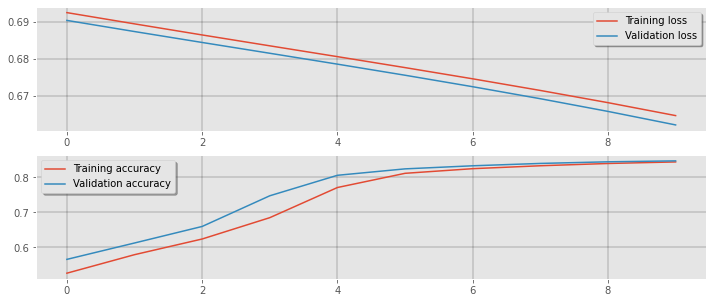

In [22]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], label="Training loss")
ax[0].plot(history.history['val_loss'], label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], label="Training accuracy")
ax[1].plot(history.history['val_acc'], label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

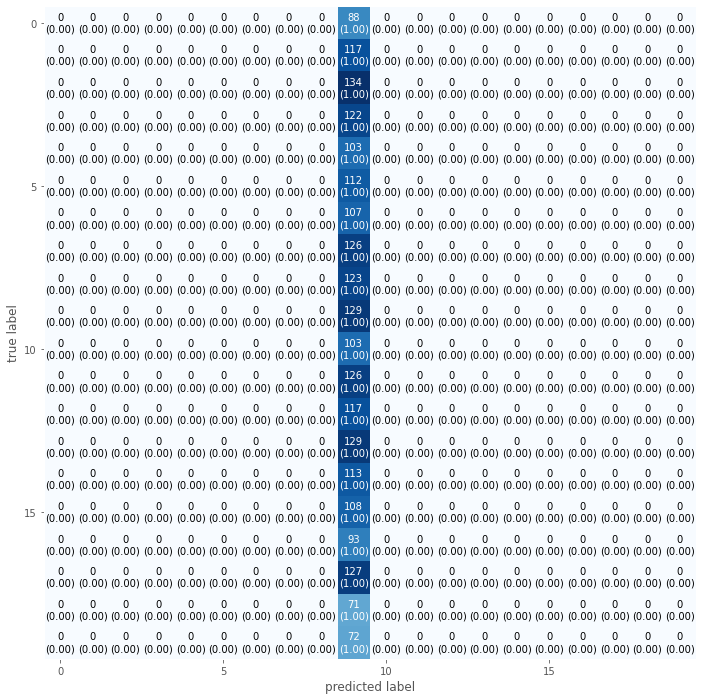

In [23]:
y_pred = model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                figsize =(12,12))